## Introduction


### Time Series with External Regressors

This is a note on working with time series *with* external regressors, *and* specifying if the external regressors are treated as transient (short impulse response) or durable (long term impulse response).

The system we are interested in is the following with `y_auto` (unobserved), `y_imp` (unobserved), and `y_total = max(0, y_auto + y_imp + e)` where `e` is mean-zero independent noise term.

```
  y_auto[i] ~ beta_auto_intercept + beta_auto . (y_auto[i-l1], ..., y_auto[i-lk]) + beta_durable . beta_durable[i]
  y_imp[i] ~ effect_shift + beta_transient . beta_transient[i]
  y[i] = y_auto[i] + y_imp[i] + e[i]
```

Where `l1`, ..., `lk` are our lags, `beta_durable[]` are durable external regressors, and `beta_transient[]` are transient external regressors. For our application we consider `y_auto` to be a loyal subset of customers, and `y` the total observed customers.  The idea is the observed `y` is the sum of unobserved `y_auto` and unobserved transient (or non-loyal) customers.

We will call external regressors `x` that do not contribute to future time indices (as above): "transient". We call external regressors `z` that contribute to `y_auto`: "durable." We will call a model that matches the structure of the assumed data generating process as "structure respecting", and one that does not as "structure disrespecting." Having a good estimate of the model structure is a positive and useful inductive bias.


## Setting up our example


In [1]:
# set up Python
import json
import numpy as np
import pandas as pd
import plotnine
from plotnine import *

from nested_model_fns import (
    build_example,
    train_test_split,
    plot_model_quality,
    apply_linear_model_bundle_method,
)


# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
# start our pseudo-random generator at a known state for reproducibility
rng = np.random.default_rng(2024)

Our example data is generated from the following specifications.  Note, to illustrate our points we are setting up a strong `sin(x)` style trend with a lot less noise than is seen in business problems (though possibly of the scale seen in scientific problems).


In [3]:
# specify example
generating_lags = (1, 2)
modeling_lags = (1, 2)
gen_scale = 5.2
gen_shift = 15.0
beta_auto = (2 * np.cos(np.pi / 19), -1)  # angle addition
beta_auto_intercept = gen_scale * gen_shift * (1 - np.sum(beta_auto))
effect_shift = -10.4
# external regressors
beta_durable = (9.2,)
beta_transient = (19.1,)
error_scale = 3.2

generating_params = {
    "beta_auto_intercept": beta_auto_intercept,
    "effect_shift": effect_shift,
    "beta_auto": beta_auto,
    "beta_durable": beta_durable,
    "beta_transient": beta_transient,
    "generating_lags": generating_lags,
    "modeling_lags": modeling_lags,
    "error_scale": error_scale,
}


In [4]:
# save parameters so other steps can use them
with open("generating_params.json", "w") as file:
    json.dump(generating_params, file)

In [5]:
# build the example
d_example = build_example(
    rng=rng,
    generating_lags=generating_lags,
    beta_auto=beta_auto,
    beta_auto_intercept=beta_auto_intercept,
    effect_shift=effect_shift,
    beta_durable=beta_durable,
    beta_transient=beta_transient,
    error_scale=error_scale,
)

In [6]:
# string form of external regressors for grouping in graphs
d_example["ext_regressors"] = "regular point"
d_example.loc[d_example["x_transient_0"] != 0, "ext_regressors"] = "transient impact"
d_example.loc[d_example["x_durable_0"] != 0, "ext_regressors"] = "durable impact"
d_example.loc[(d_example["x_durable_0"] != 0) & (d_example["x_transient_0"] != 0), "ext_regressors"] = "durable and transient impacts"

In [7]:
# split into test and train by time
d_train, d_test = train_test_split(d_example, test_length=20)
d_train.to_csv("d_train.csv", index=False)
d_test.to_csv("d_test.csv", index=False)

In [8]:
# show training data
d_train

,time_tick,x_durable_0,x_transient_0,y,ext_regressors
0,0,0,0,69.0,regular point
1,1,0,0,73.0,regular point
2,2,0,0,65.0,regular point
3,3,0,0,72.0,regular point
4,4,1,0,80.0,durable impact
...,...,...,...,...,...
975,975,0,0,55.0,regular point
976,976,0,0,65.0,regular point
977,977,0,0,84.0,regular point
978,978,0,0,94.0,regular point


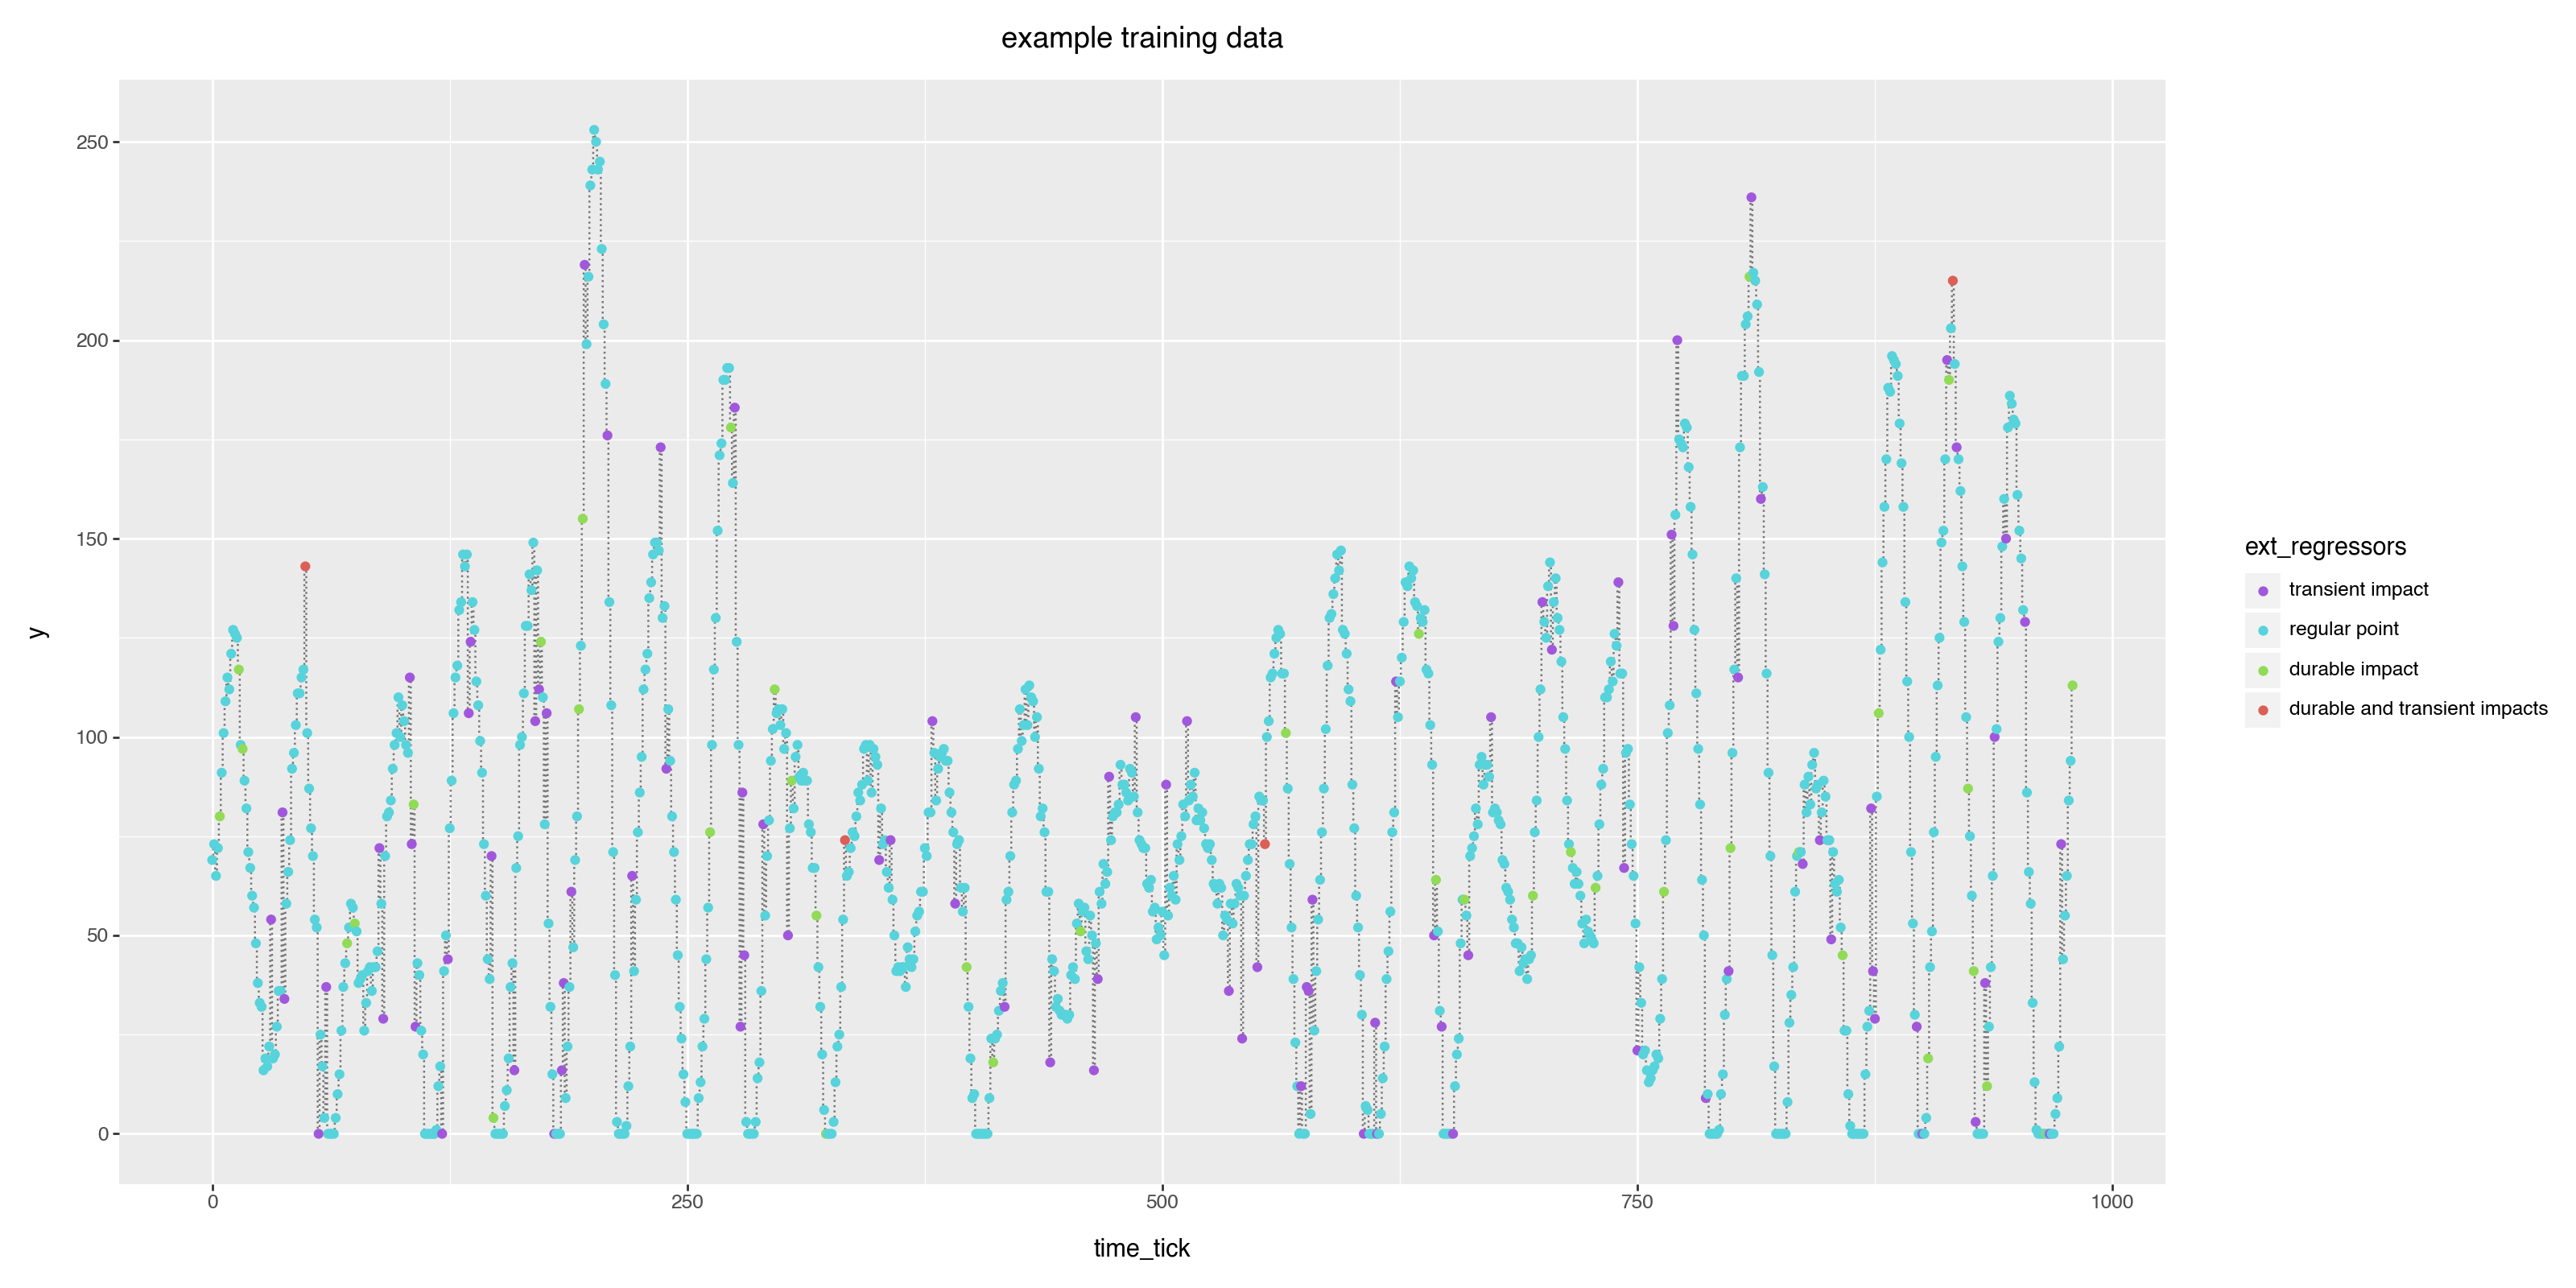

In [9]:
# plot training data
(
    ggplot(data=d_train, mapping=aes(x="time_tick", y="y"))
    + geom_step(
        alpha=0.5,
        direction="mid",
        linetype="dotted",
    )
    + geom_point(mapping=aes(color="ext_regressors"))
    + guides(color=guide_legend(reverse=True))
    + ggtitle("example training data")
)

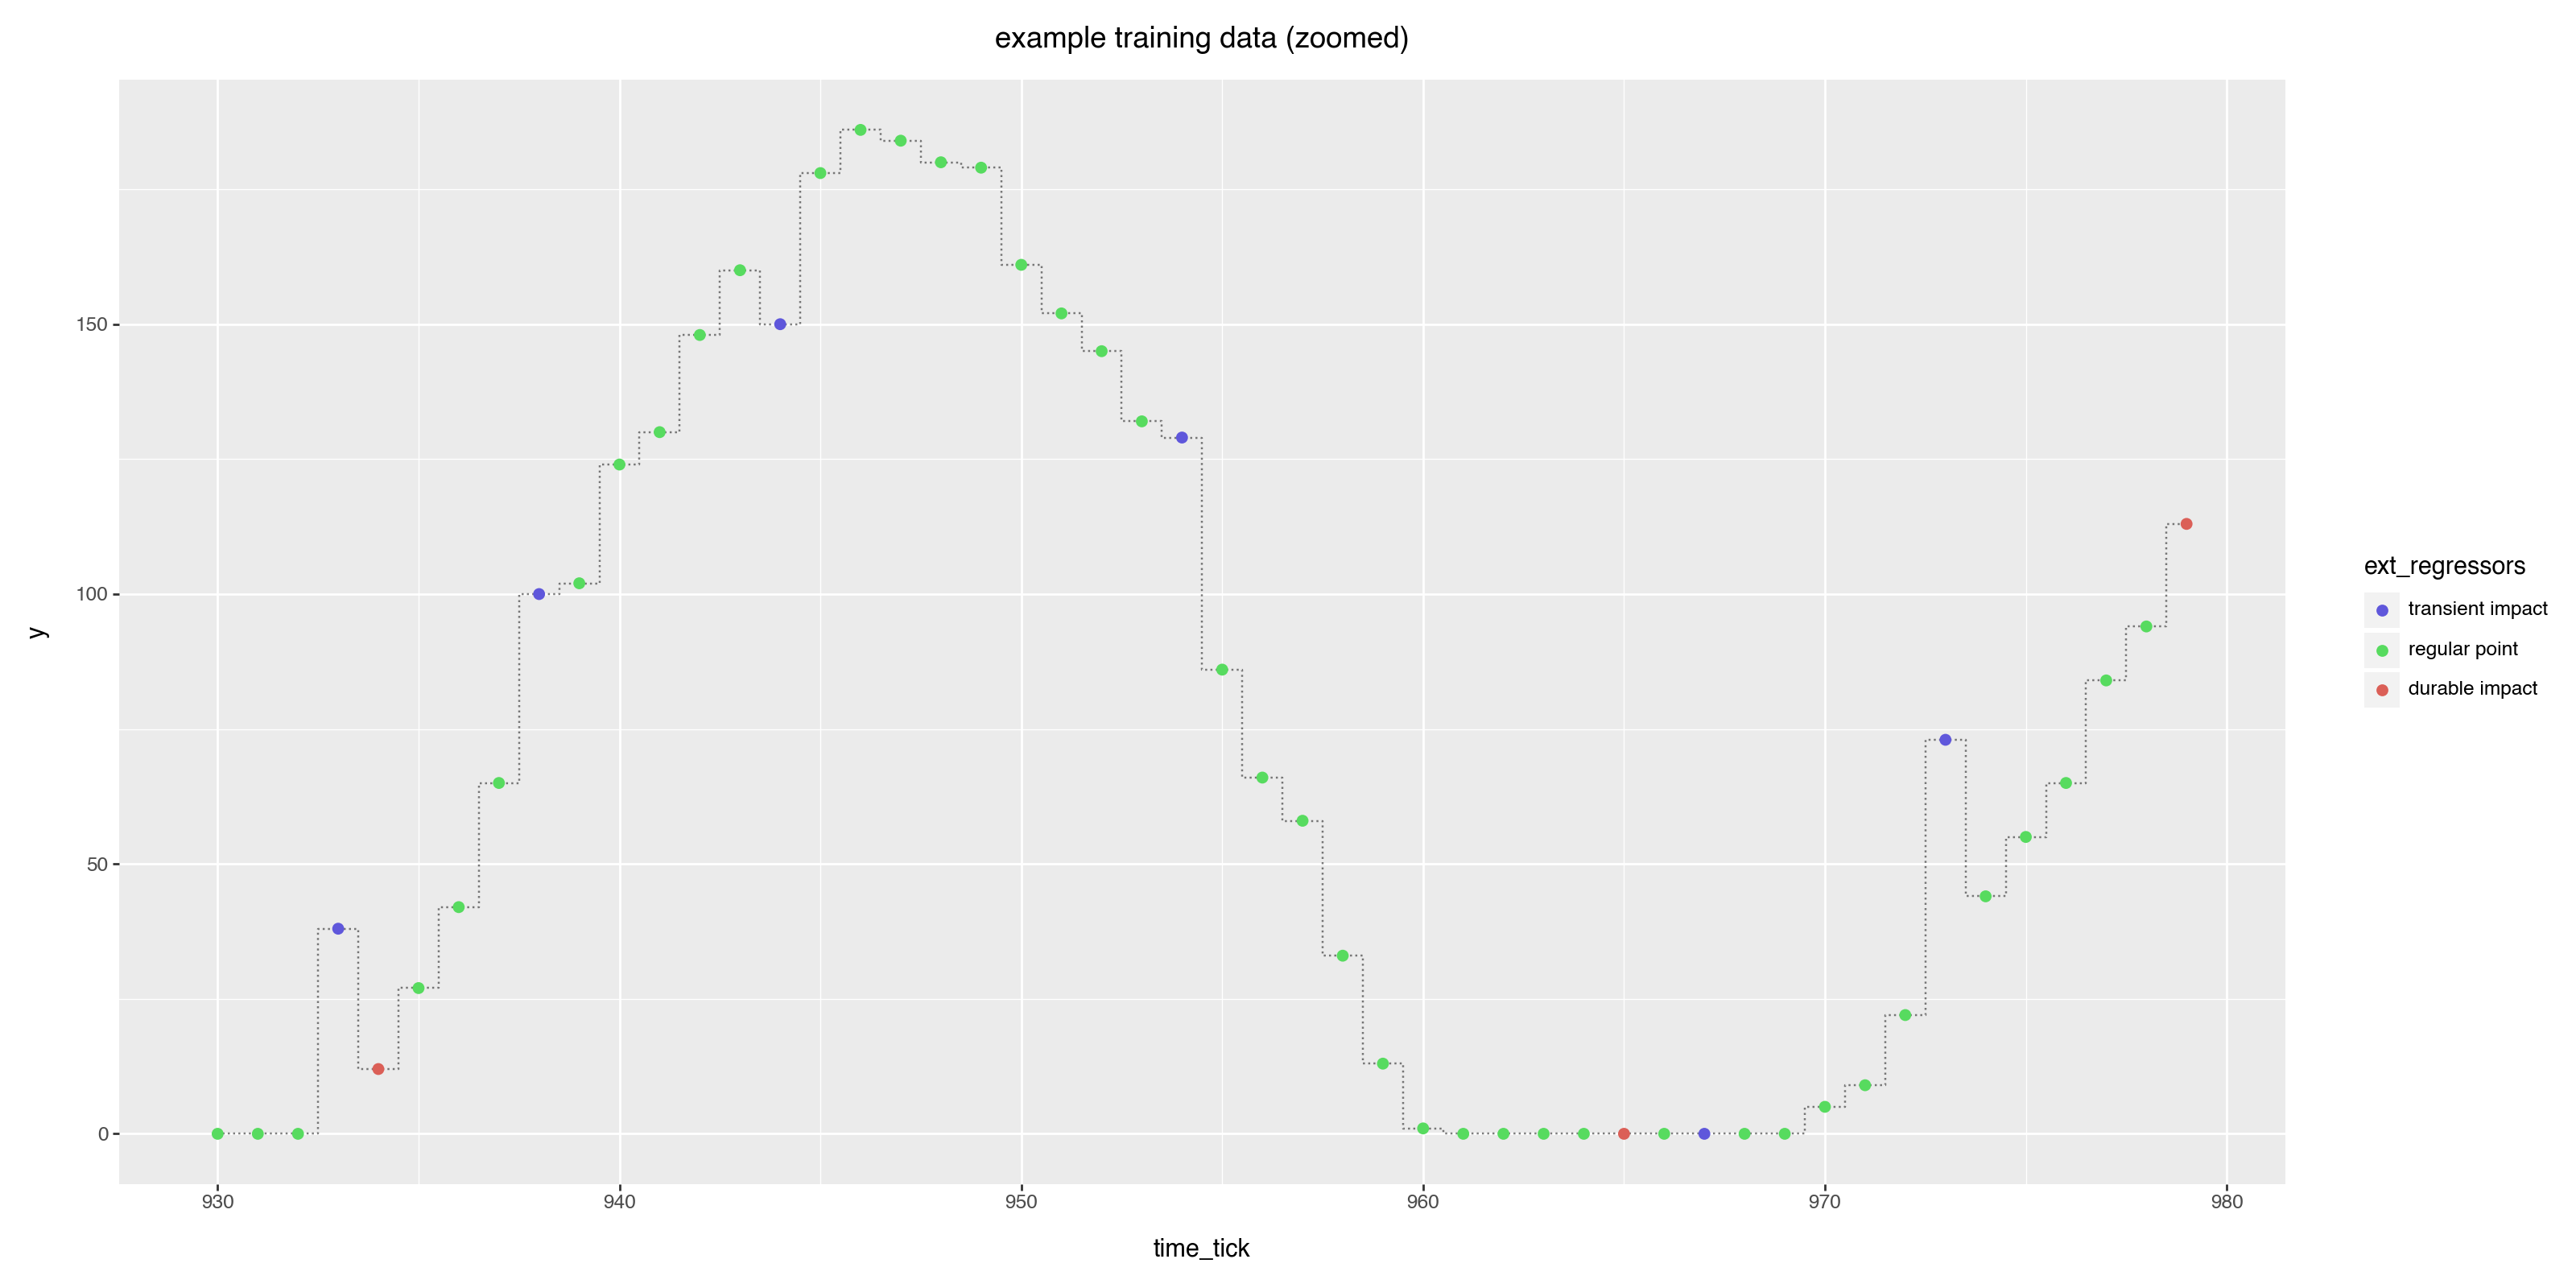

In [10]:
# zoom in on training data and annotate
d_train_zoomed = d_train.loc[
    d_train["time_tick"] >= (d_train.shape[0] - 50), :
].reset_index(drop=True, inplace=False)
(
    ggplot(data=d_train_zoomed, mapping=aes(x="time_tick", y="y"))
    + geom_step(
        alpha=0.5,
        direction="mid",
        linetype="dotted",
    )
    + geom_point(mapping=aes(color="ext_regressors"), size=2)
    + guides(color=guide_legend(reverse=True))
    + ggtitle("example training data (zoomed)")
)

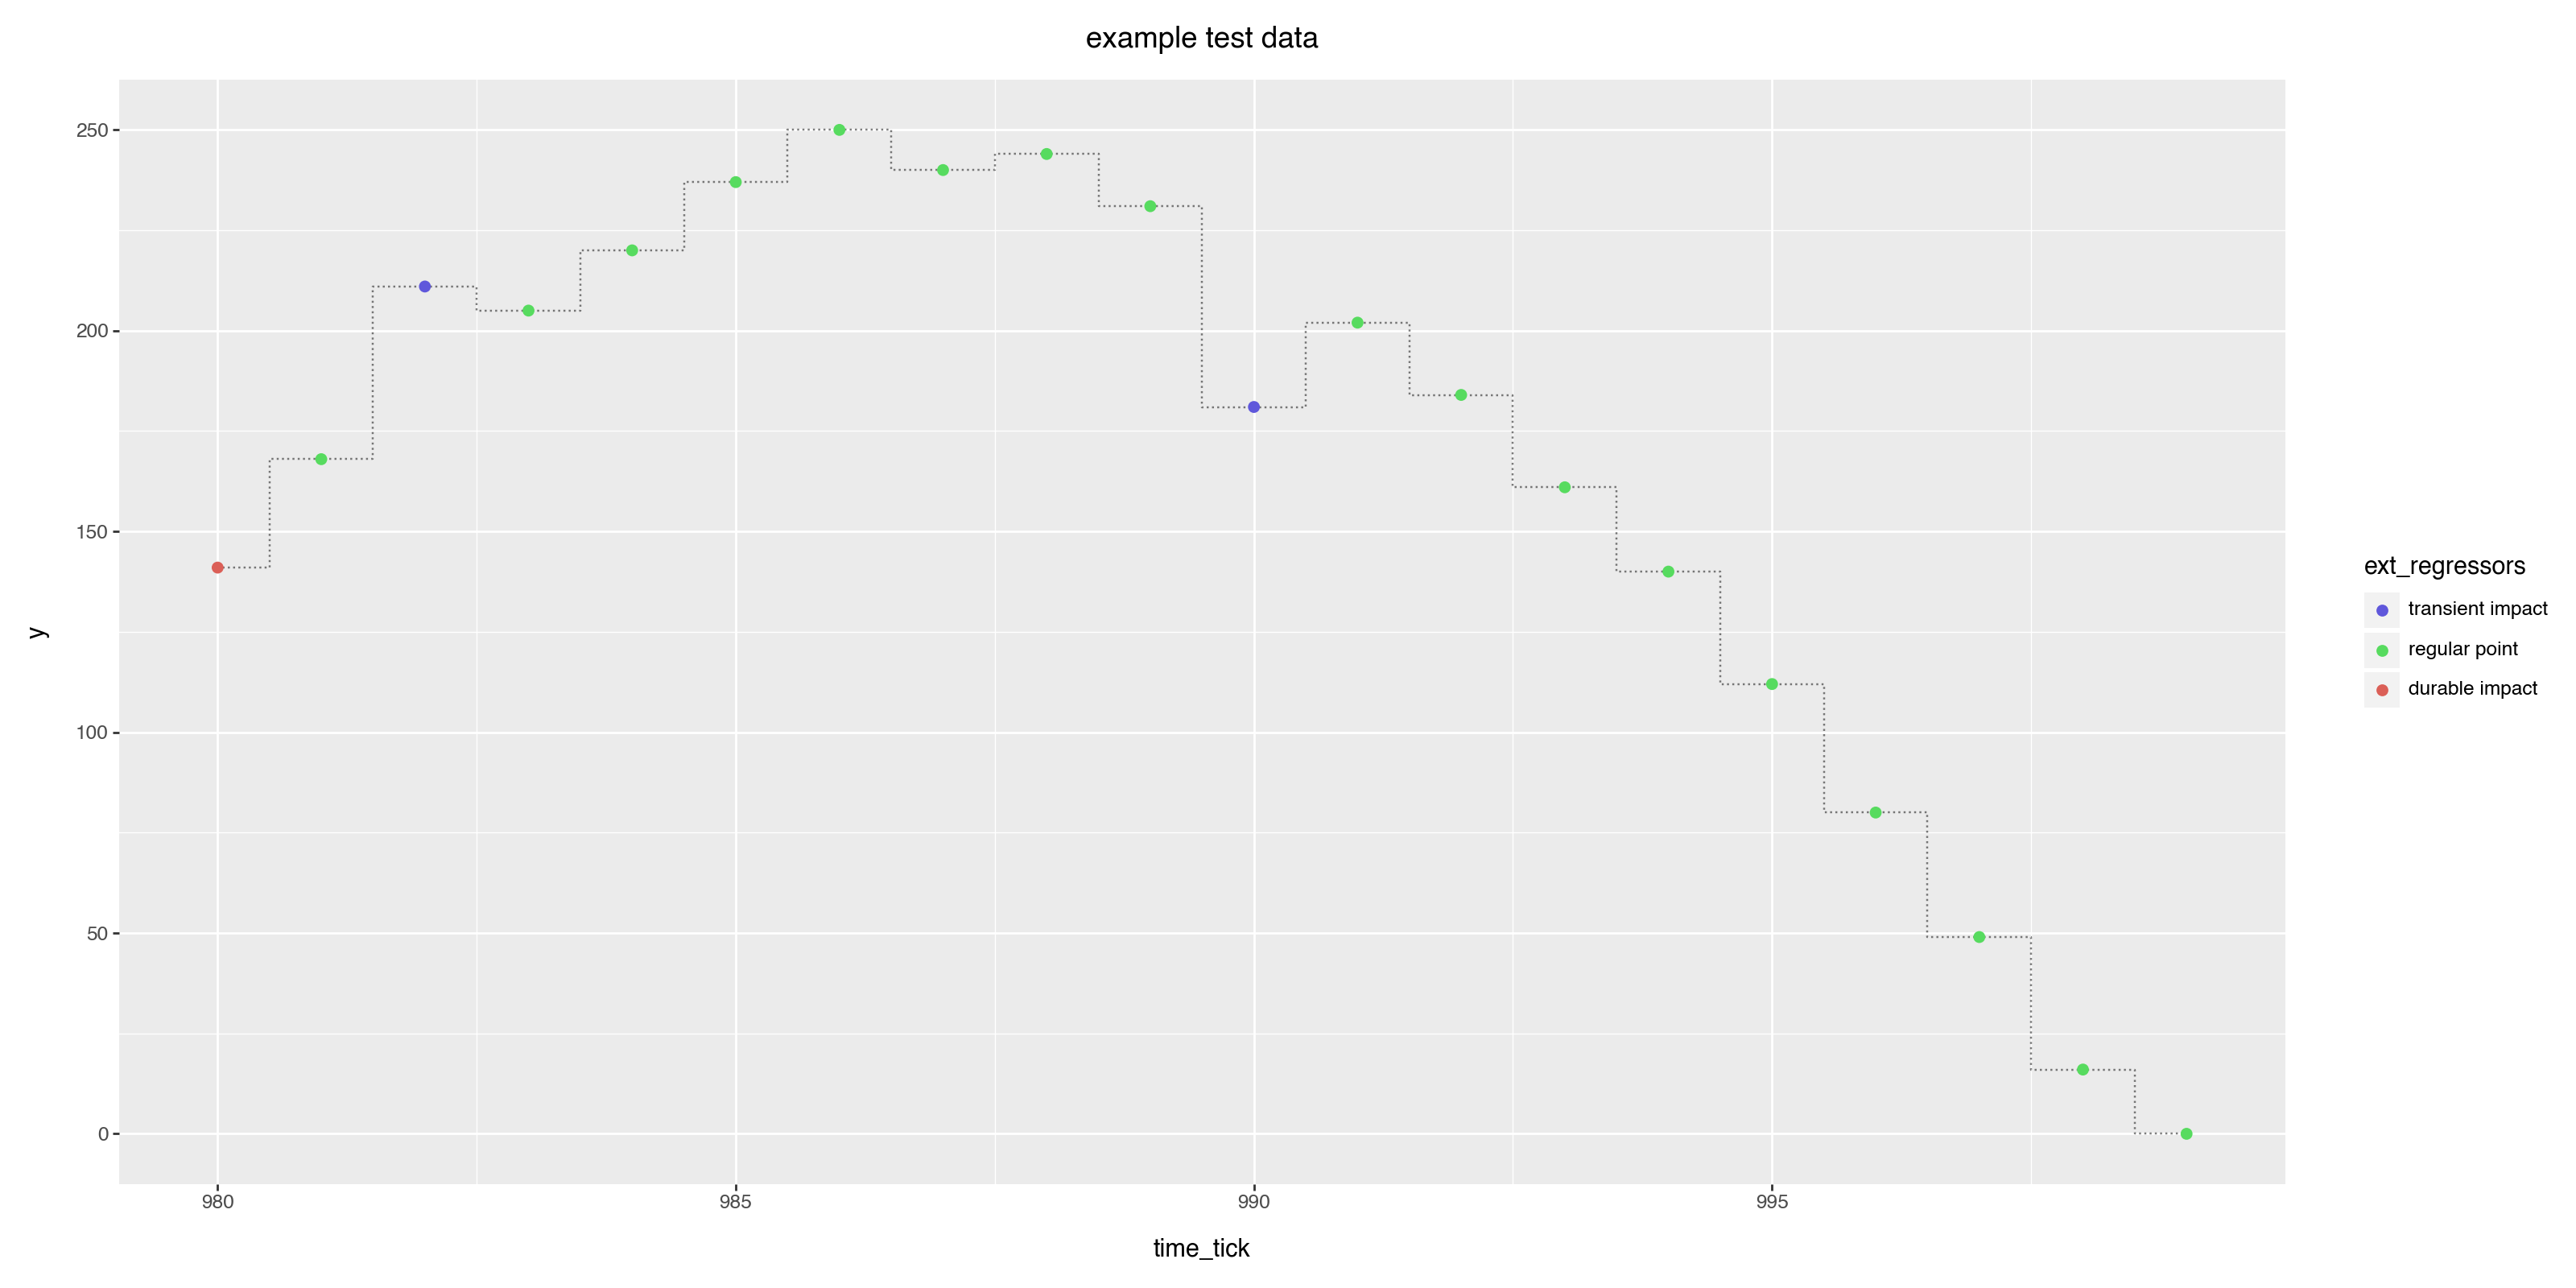

In [11]:
# plot test data
(
    ggplot(data=d_test, mapping=aes(x="time_tick", y="y"))
    + geom_step(
        alpha=0.5,
        direction="mid",
        linetype="dotted",
    )
    + geom_point(mapping=aes(color="ext_regressors"), size=2)
    + guides(color=guide_legend(reverse=True))
    + ggtitle("example test data")
)

## A common lie

Here we build what we call "the usual lie graph" in time series. This is: showing the one time period performance on a scatter plot. This is ignores applications that need multiple period out predictions. Also, trivial and useless predictions (such as use the last time tick) often look great in this presentation.

In [12]:
d_example = d_train.loc[d_train["time_tick"] >= (d_train.shape[0] - 50), :].reset_index(
    drop=True, inplace=False
)
d_example["liar's prediction"] = d_example["y"].shift(1)
d_example = d_example.loc[
    pd.isnull(d_example["liar's prediction"]) == False, :
].reset_index(drop=True, inplace=False)

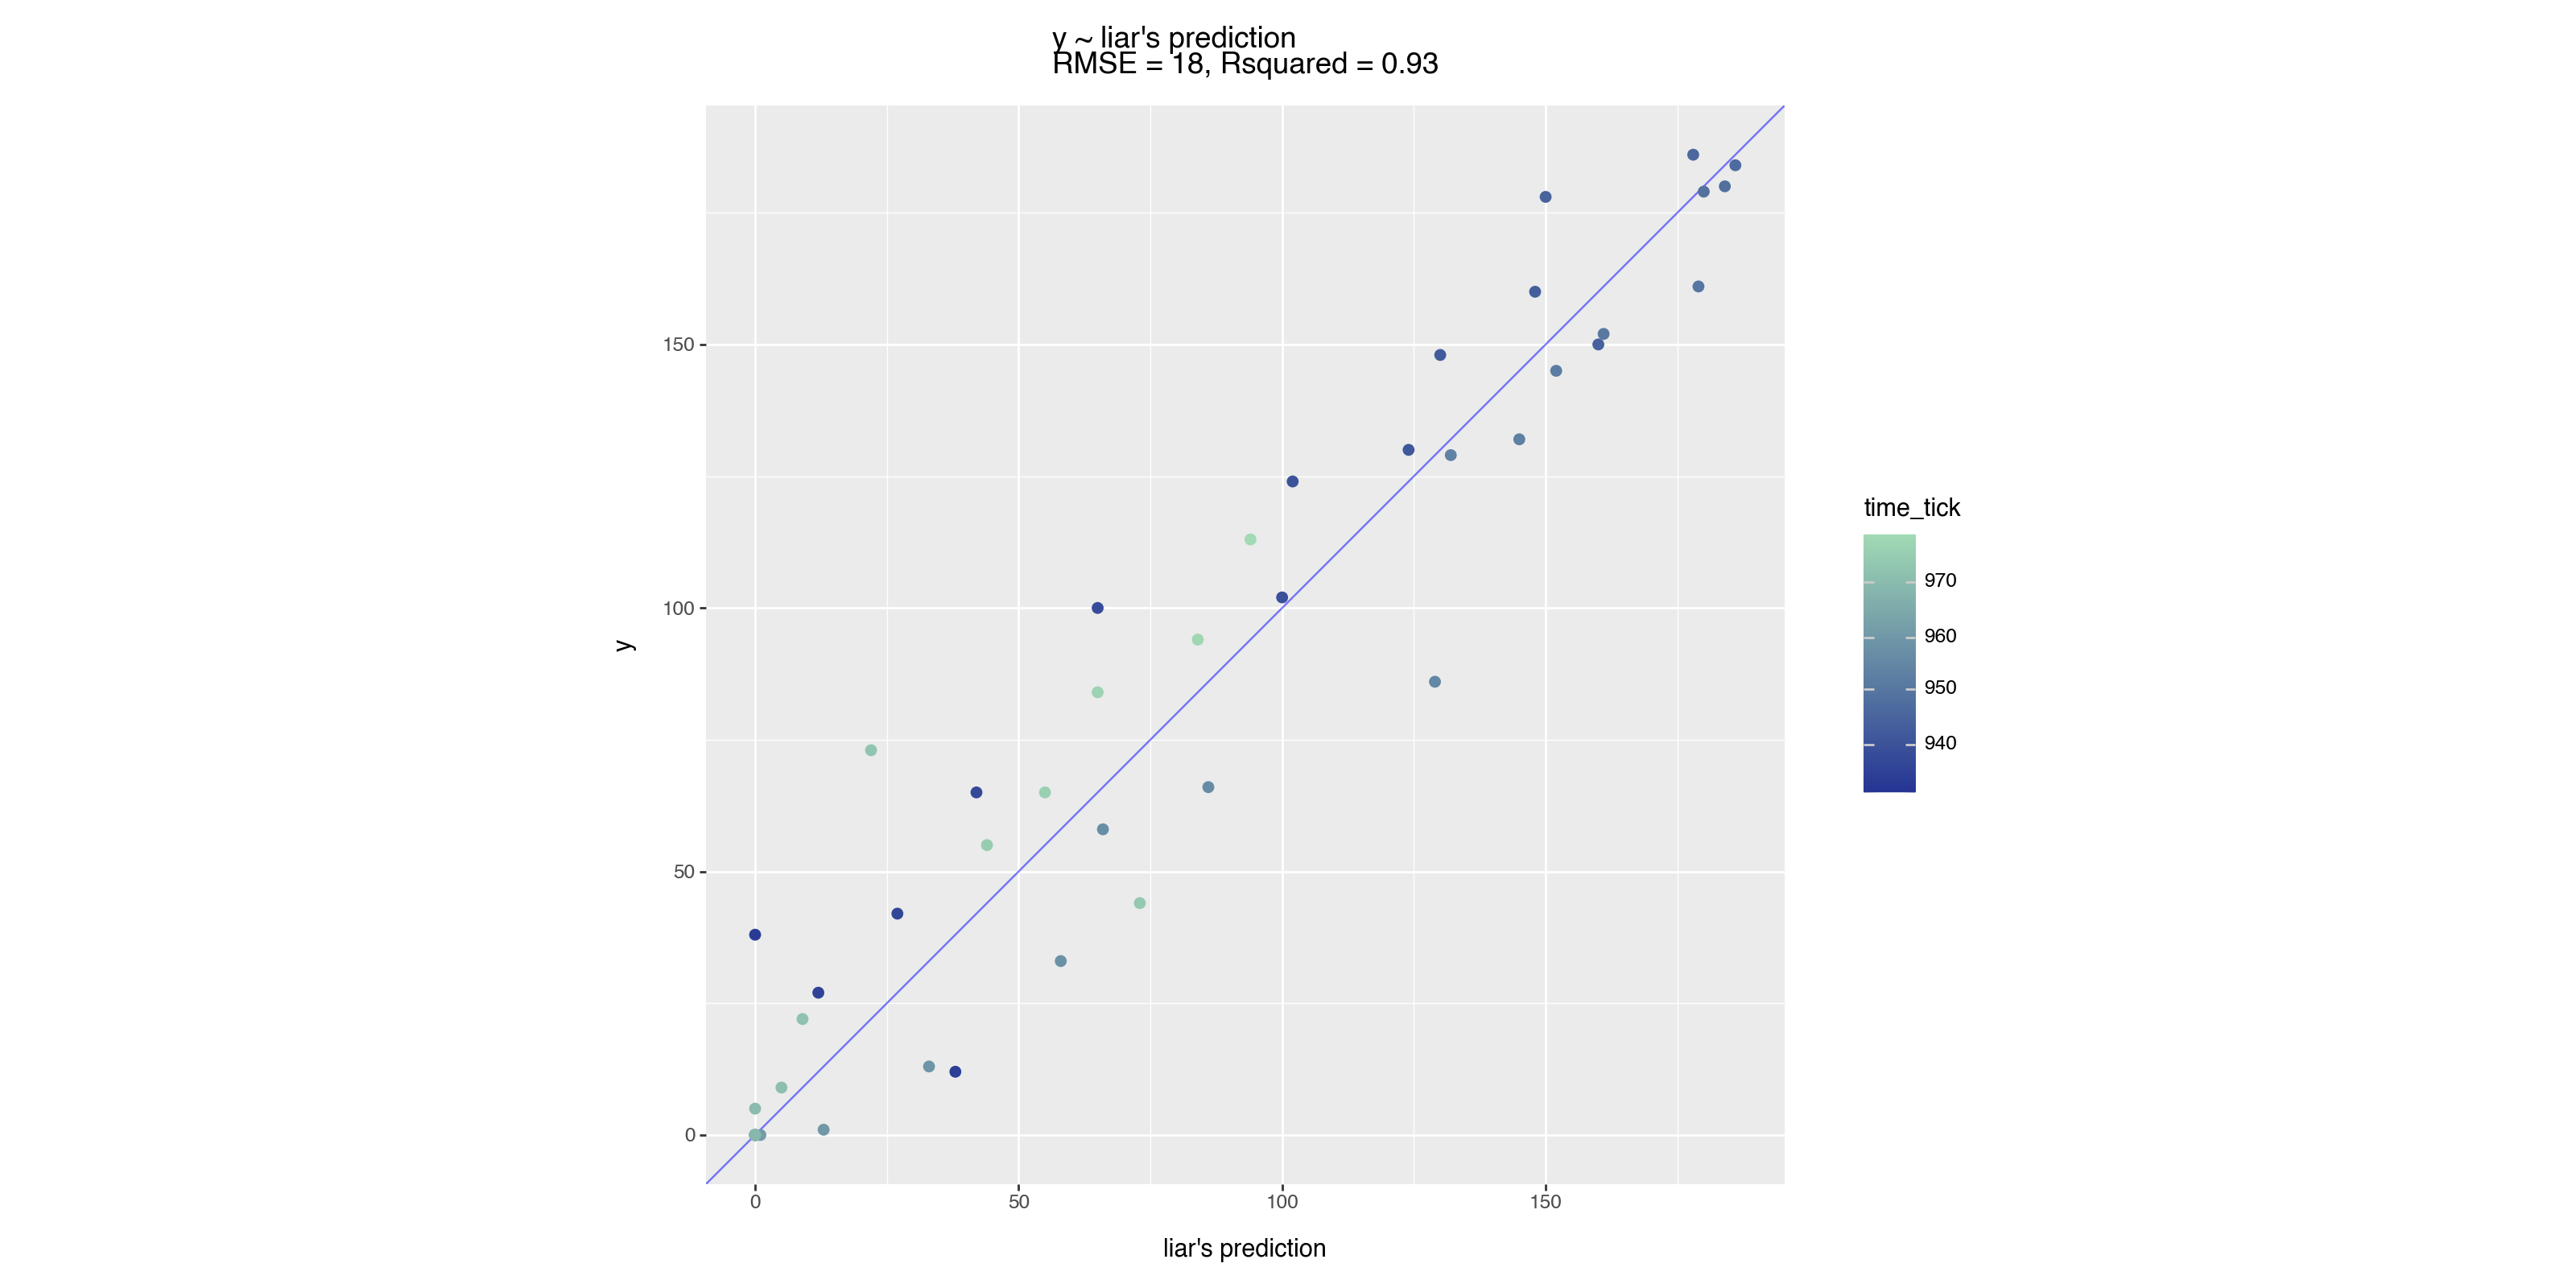

In [13]:
plot_model_quality(
    d_example,
    result_name="liar's prediction",
)

A more reliable evaluation is: plot date or time on the x-axis, as that is the important control in time series. Then document what is being plotted: i.e. how many time steps out one is predicting. Below we show using the last known value to predict into the held-out test period. This emphasizes that in addition to not predicting the future: the "use the previous value" predictor is often not realizable in production (as once we get two steps out we no longer know the previous time step).

In [14]:
d_test["liar's prediction"] = d_example.loc[d_example.shape[0] - 1, "y"]

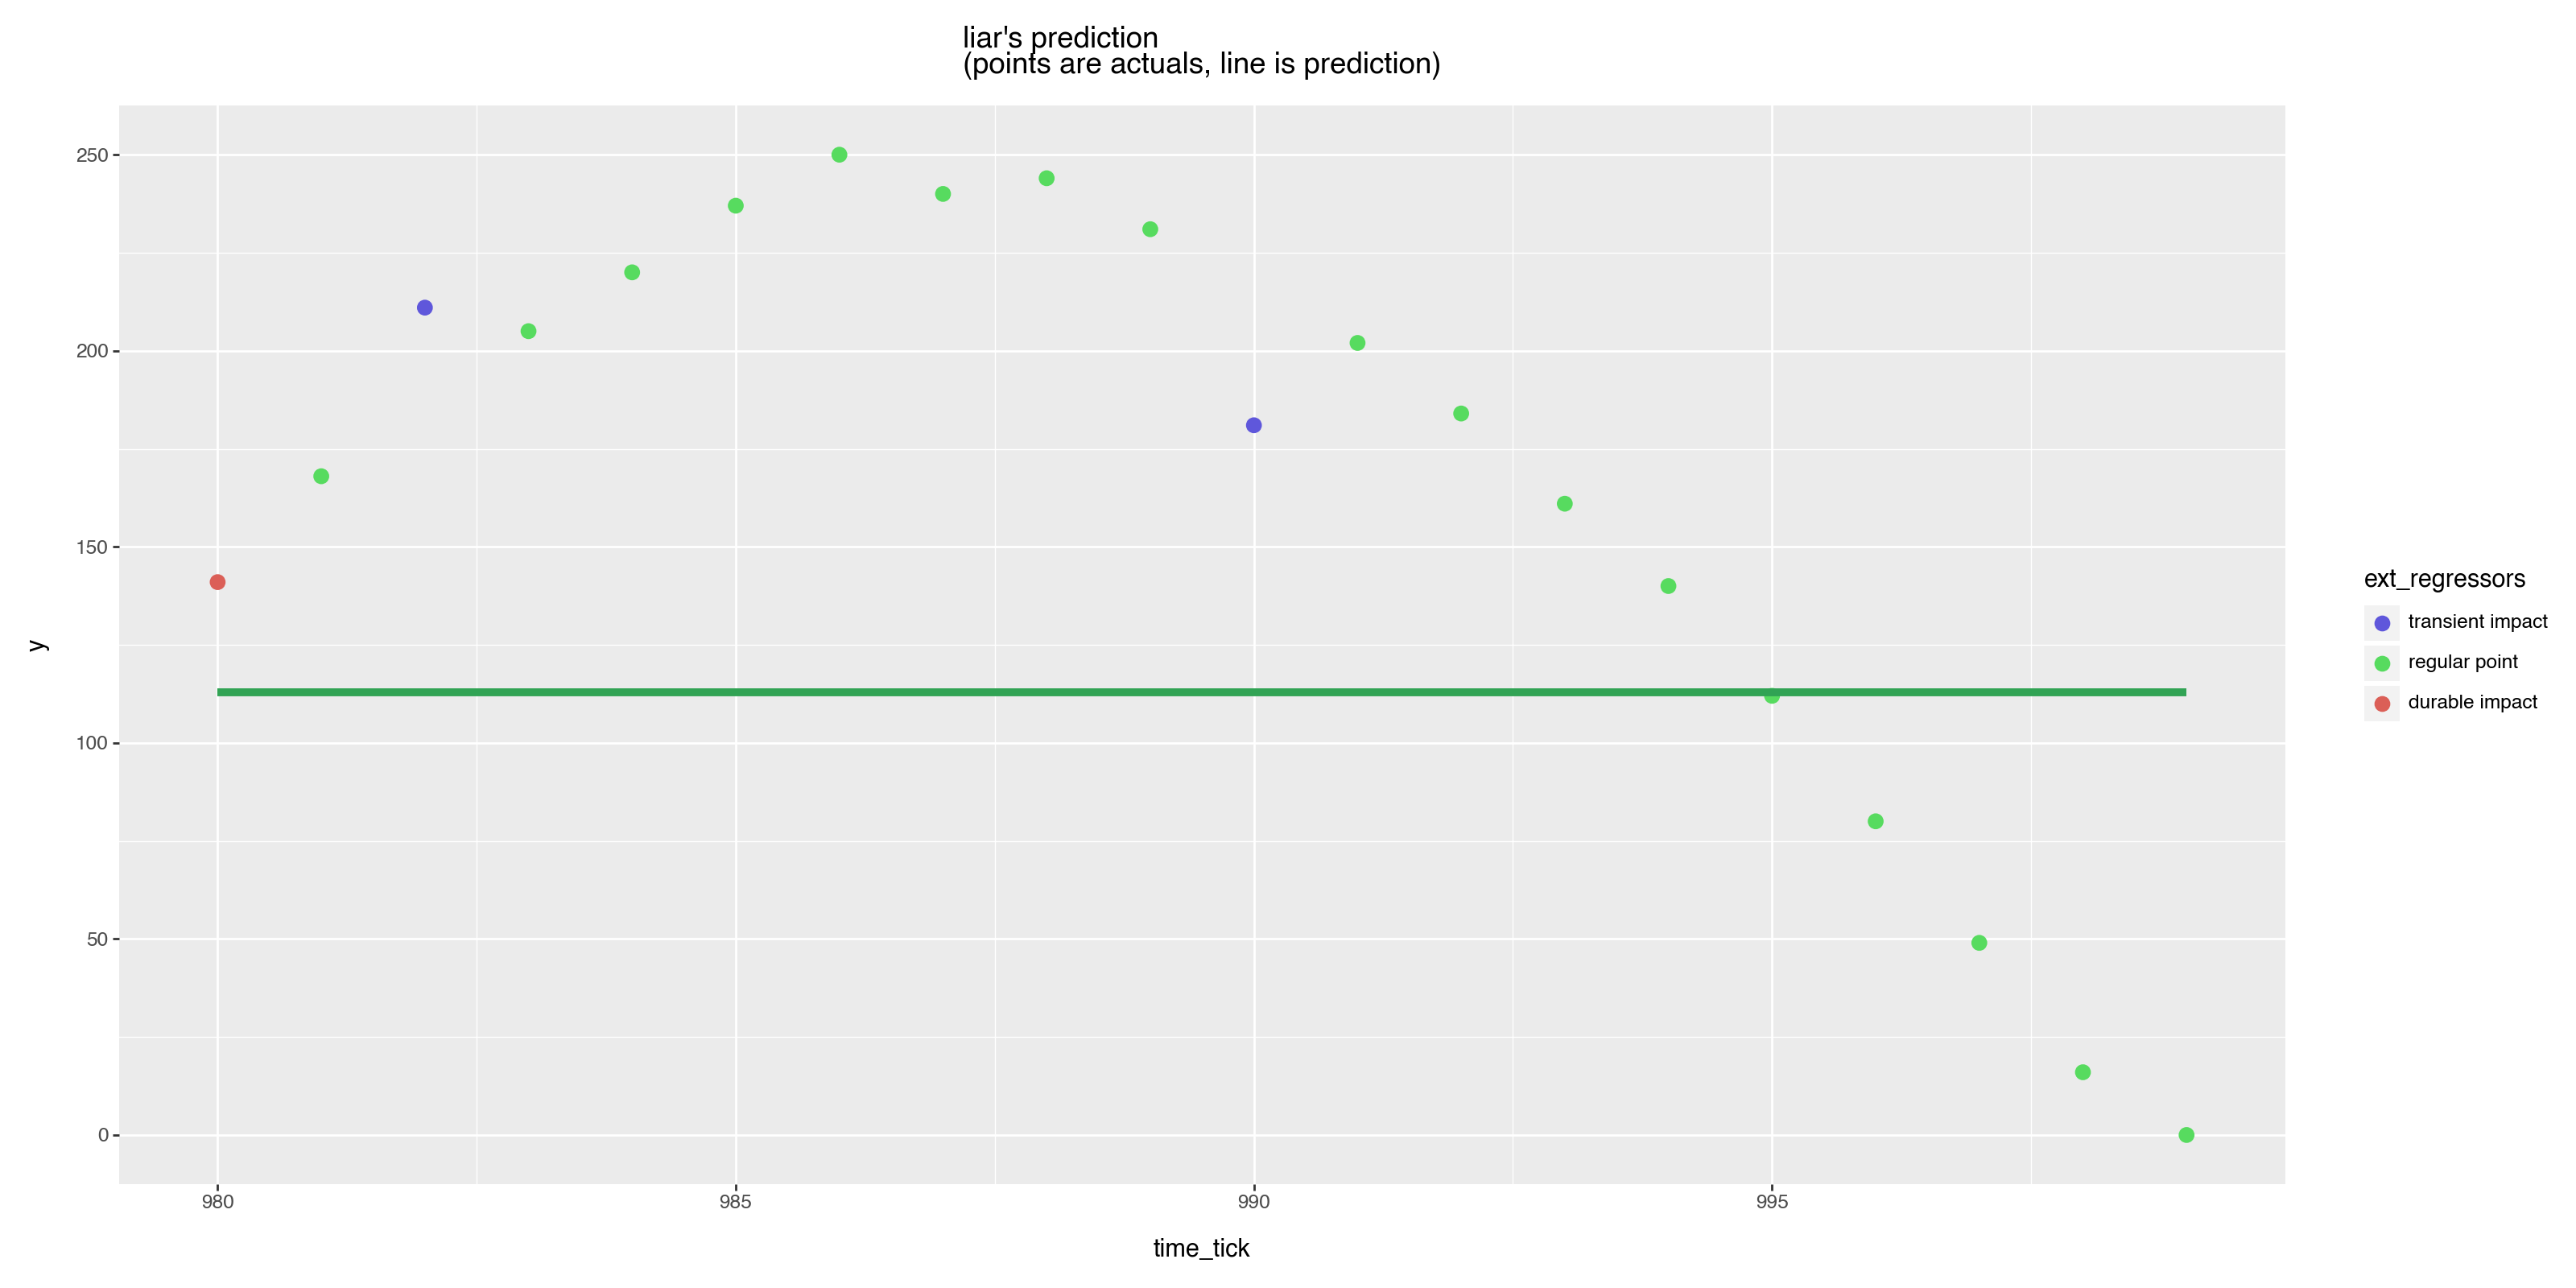

In [15]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis="columns"), :],
        mapping=aes(x="time_tick"),
    )
    + geom_point(aes(y="y", color="ext_regressors"), size=3)
    + geom_step(
        aes(y="liar's prediction"),
        size=2,
        color="#31a354",
        direction="mid",
    )
    + guides(color=guide_legend(reverse=True))
    + ggtitle("liar's prediction\n(points are actuals, line is prediction)")
)

We are not recommending a special evaluation discipline for time series. Quite the opposite. We are suggesting use standard evaluation methods: insist on a standard hold-out procedure simulating how you might actually use the predictions in practice. This dis-recommends time-series specific ideas or optimizations such as sliding windows.

## Adding external regressors compatible with stated problem structure


Let's try a linear model bundle with transient and durable regressors.

The fitting procedure here is a bit ad-hoc, but there are libraries that systematically deal with this as a nested regression.


In [16]:
d_test["linear model bundle (correct external regressor structure)"] = (
    apply_linear_model_bundle_method(
        modeling_lags=modeling_lags,
        durable_external_regressors=["x_durable_0"],
        transient_external_regressors=["x_transient_0"],
        d_train=d_train,
        d_apply=d_test,
    )
)

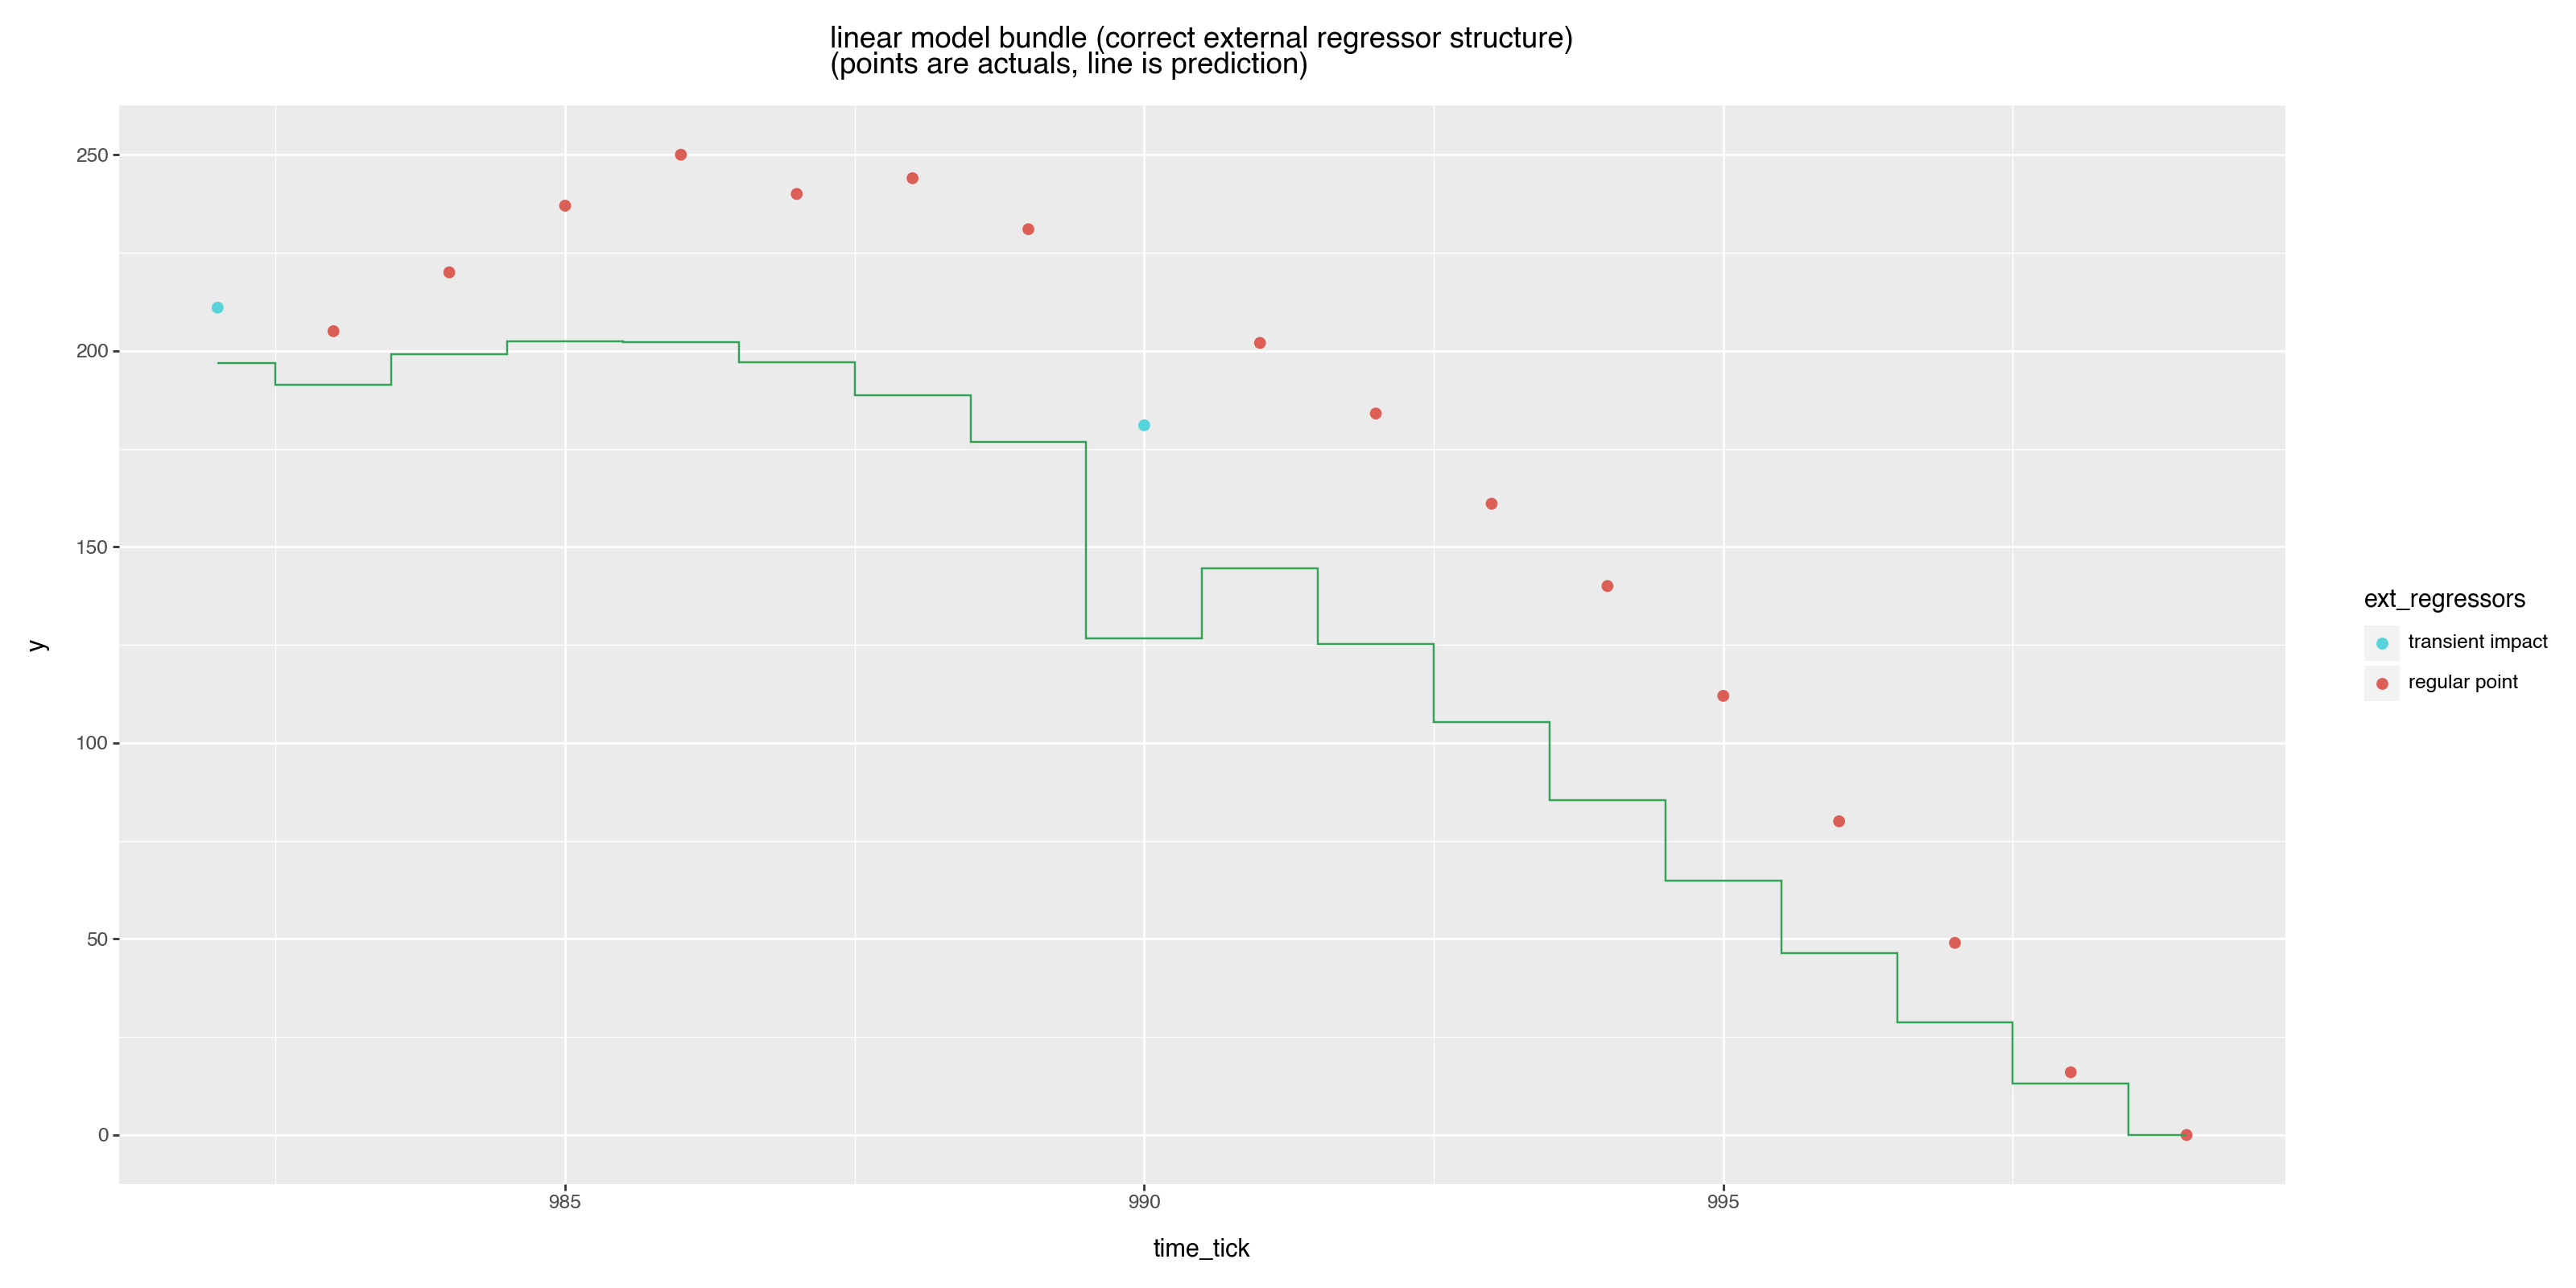

In [17]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis="columns"), :],
        mapping=aes(x="time_tick"),
    )
    + geom_point(aes(y="y", color="ext_regressors"), size=2)
    + geom_step(
        aes(y="linear model bundle (correct external regressor structure)"),
        color="#31a354",
        direction="mid",
    )
    + guides(color=guide_legend(reverse=True))
    + ggtitle(
        "linear model bundle (correct external regressor structure)\n(points are actuals, line is prediction)"
    )
)

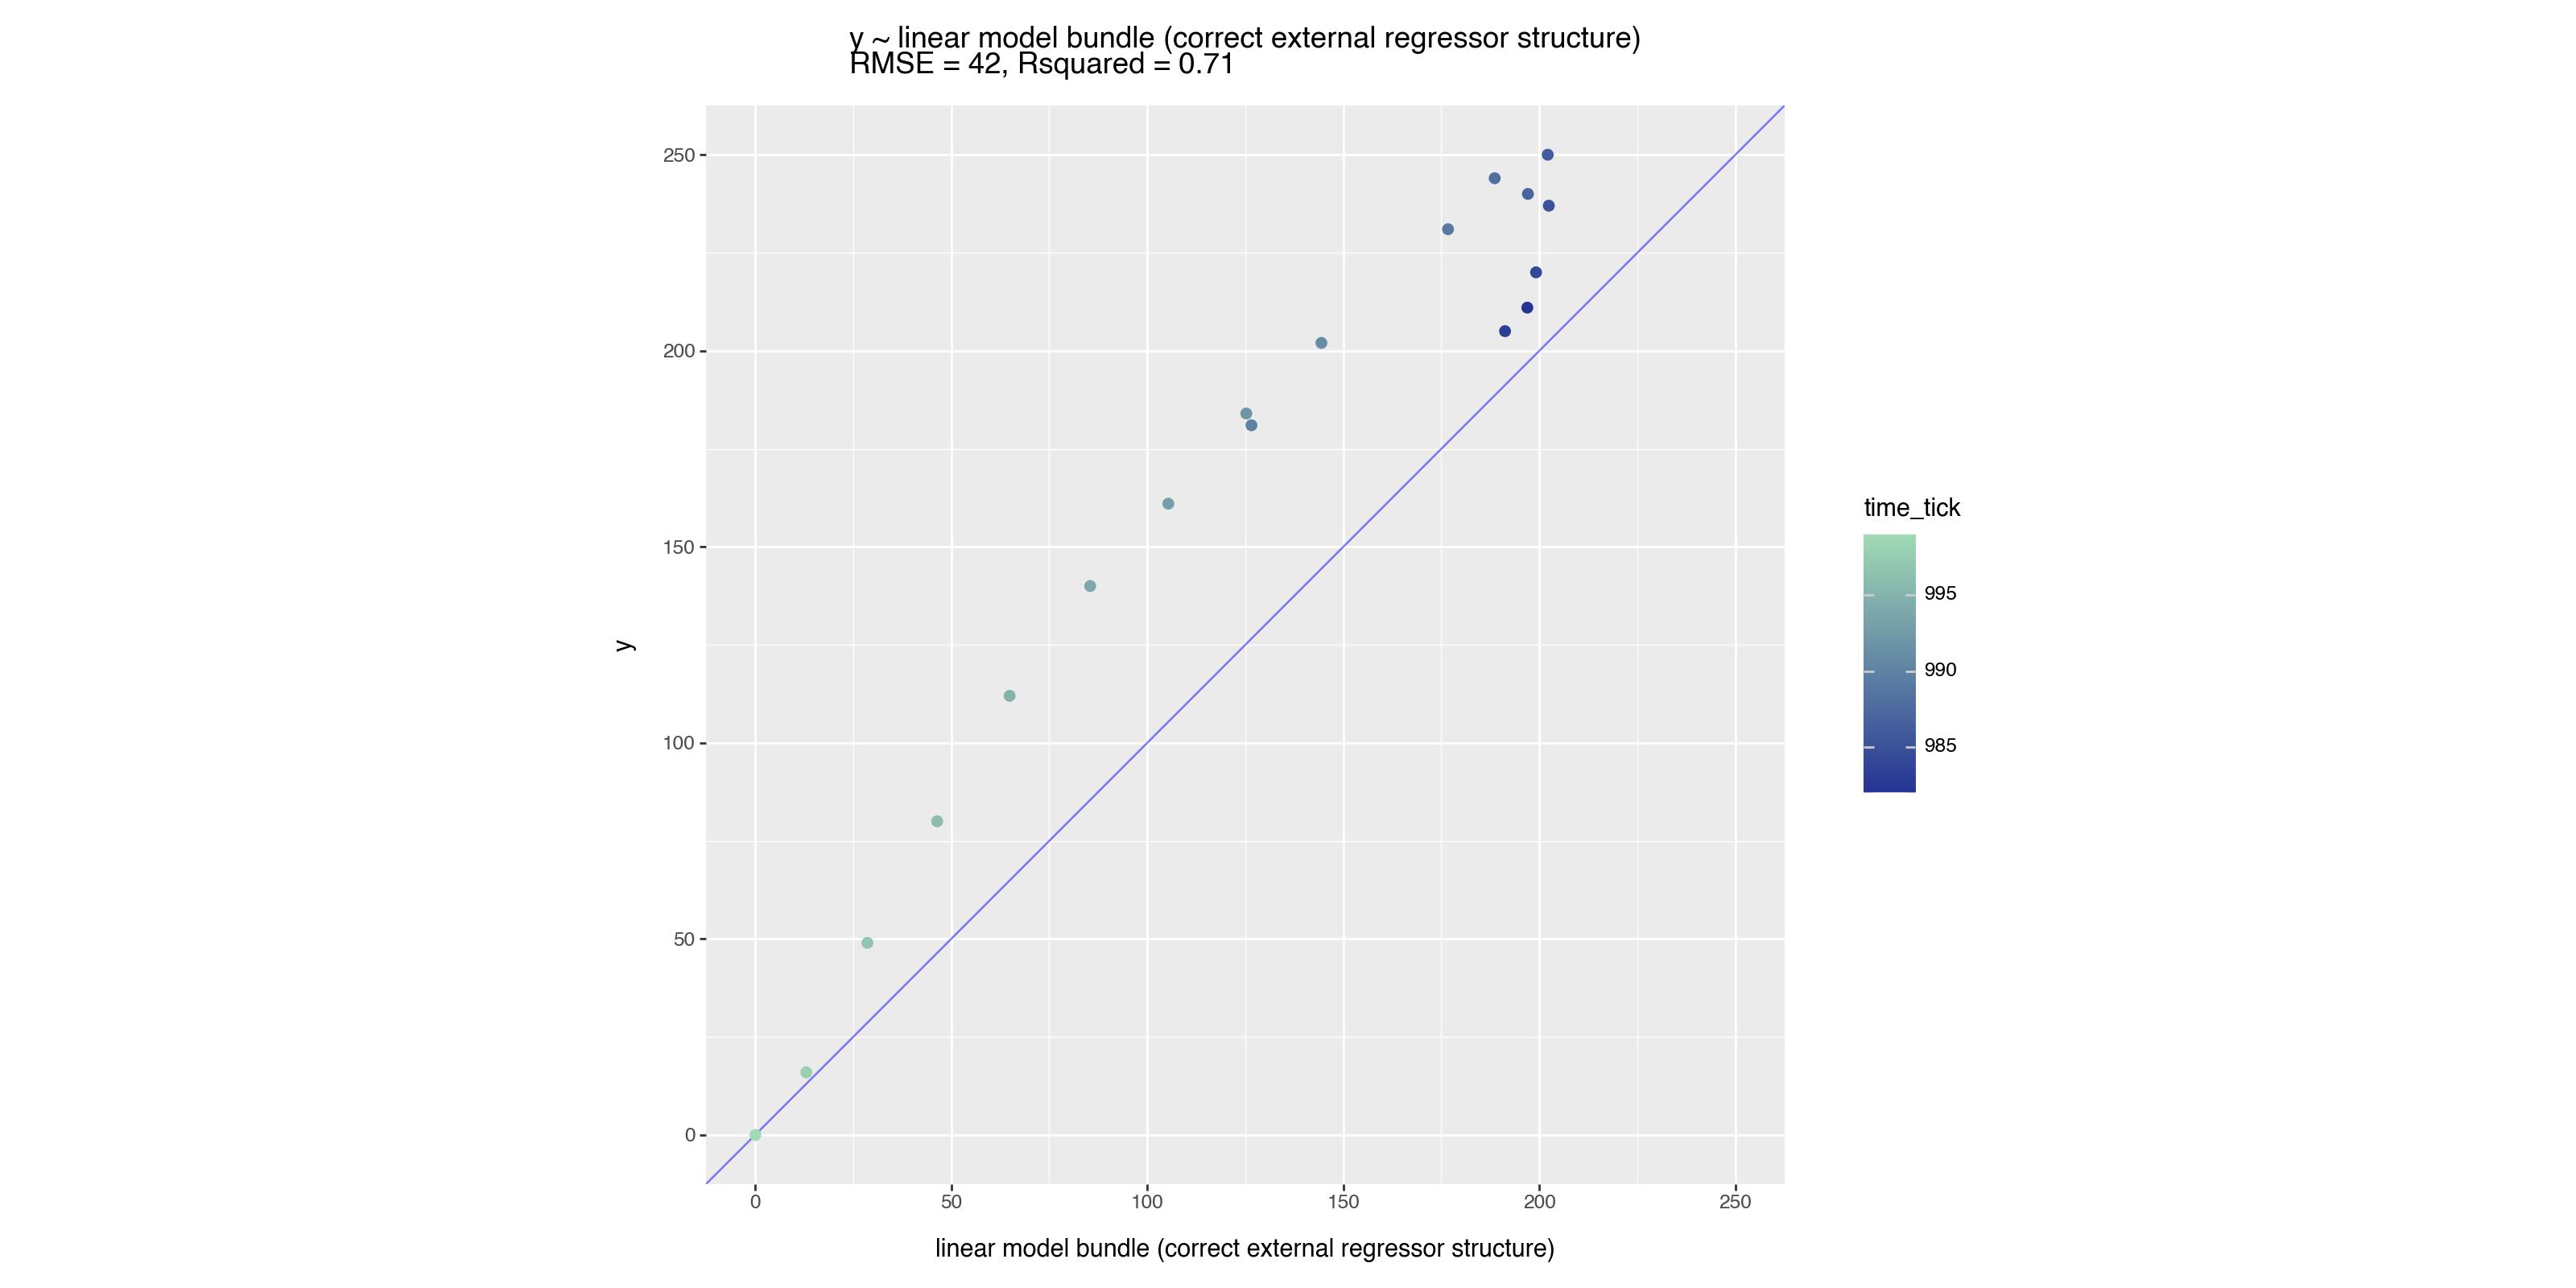

In [18]:
plot_model_quality(
    d_test.loc[
        pd.isnull(d_test["linear model bundle (correct external regressor structure)"])
        == False,
        :,
    ],
    result_name="linear model bundle (correct external regressor structure)",
)

This is a good result. The code to do this was a bit "one off", but it allows one to specify the desired external regressor effects in a way that may not be obvious when forced to adapt the modeling ask to standard packages.

## Solving again with the Bayesian "big hammer"

Please [Stan_soln.ipynb](Stan_soln.ipynb). Here we use the very find control Stan offers in problem specification to get an even better inference.


## Standard packages

Both the forecast and fable R packages [solve the regression with ARIMA residuals formulation quite well](https://github.com/WinVector/Examples/blob/main/TimeSeries/ts_example.md). The model quality *is at least as good as* the linear functional bundle method, though not as good as the Stan solution.


However there is a slight application gap, as our problem isn't truly a regression with ARIMA residuals. So to model it that way we are forced to ignore some model structure. Some more ideas (such as integrating external residuals) can in fact improve the fidelity of the model, but those techniques can introduce their own problems.


## Conclusion


For business forecasting problems, one often wants to specify specific external regressors with specific problem structure. It turns out this is often not a standard model such as ARIMAX, SARIMAX. However, there are tools (such as Stan) that can model fairly arbitrary problem structure.
